# <center>Lab 6: Dimension Reduction and Differential Privacy</center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>


## 0. Overview

In this lab, we will:
- Discuss motivations for dimensionality reduction in machine learning
- Introduce two methods for dimensionality reduction: random projection and principal component analysis (PCA)
- Relate PCA to the eigendecomposition of the empirical covariance matrix
- Visualize the principal components of an image dataset
- Introduce the concept of differential privacy
- Implement two mechanisms for differential privacy
- Implement a method for evaluating differential privacy 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import pickle

%matplotlib inline

## 1. Dimension reduction via random projections

##### Why reduce the dimension?

In many applications, the data $X \in \mathbb{R}^{n\times d}$ contain measurements from a large number of features. Modern computing resources make it easy to generate and store data that contains thousands or millions of features. Several challenges arise in this setting:

- The computational burden of training a model grows with $d$. Consider the simple instance of linear regression, where the MLE is given by $\hat{\beta} = (X^TX)^{-1}X^TY $. The inversion of the $d\times d$ matrix $X^TX$ has complexity $O(d^3)$.


- From the statistical learning standpoint, a large number of features requires a correspondingly large number of observations to train a model that generalizes well. The relation between $d$ and a corresponding ``good enough" $n$ can be quite unfavorabe: for example, the sample complexity of nearest neighbors is exponential in $d$ (see UML Sec. 19.2.2).


- It may be difficult or impossible to interpret a vector of coefficients estimated for all $d$ features. We have already seen one potential solution here, namely sparse estimation methods via $\ell1$ regularization. An alternative approach is to compute a smaller set of new features.

The notion of dimensionality reduction is closely related to that of compression: we seek to describe each observation $x_i \in \mathbb{R}^d$ using only $k < d$ features, in such a way as to preserve as much information as possible in the original observation. In contrast to sparse estimation, we do not require that the $k$ new features are a subset of the $d$ original features - instead, we will think of them as _functions_ of the original features. 

The question becomes: what function(s) of the original features should I take to obtain an informative, but smaller in dimension, representation of my data $X$?

##### Random projections

We will consider linear methods for dimension reduction, that is, transformations of the data matrix $X \in \mathbb{R}^{n \times d}$ from its original feature dimension $d$ to some lower dimension $k < d$ that can be represented as

$$
\tilde{X} = XW.
$$

It remains to specify how we choose $W \in \mathbb{R}^{d \times k}$. A surprising result says that we can choose $W$ _randomly_ and obtain _provable_ guarantees regarding the preservation of structure in the original data. In particular, we can study the distortion induced by $W$ through the ratio

$$
\frac{||W^Tx_1 - W^Tx_2||}{||x_1 - x_2||},
$$

where $x_1$ and $x_2$ are observations in the original feature space. If this ratio is close to 1, then dimension reduction using $W$ roughly preserves the geometric structure of the data. The celebrated __Johnson-Lindenstrauss Lemma__ (see UML Sec. 23.2) proves that this can be achieved by a $W$ with carefully selected _random_ elements.

__Lemma (Johnson-Lindenstrauss):__ Given a data set $X \in \mathbb{R}^{n \times d}$, construct the set $Q$ of all distances between observations in $X$. Let $\delta \in (0,1)$ and $k$ be an integer such that

$$
\varepsilon := \sqrt{\frac{6 \log(2 |Q| / \delta)}{k}} \leq 3.
$$

Let $W \in \mathbb{R}^{k \times d}$ be a random matrix whose entries have the distribution $\mathcal{N}(0, 1/k)$. Then, with probability at least $1-\delta$ over the choice of $W$, we have

$$
\max_{x_1, x_2 \in X} \left\vert \frac{||W^Tx_1 - W^Tx_2||^2}{||x_1 - x_2||^2} - 1 \right\vert < \varepsilon.
$$

__Exercise 1.1:__ Implement random projection to dimension $k$, using the random Gaussian matrix described in the lemma above.

In [2]:
def random_proj(X, k):
    '''
    Project n x d data matrix X down to dimension k via Gaussian features.
    '''
    n, d = X.shape
    std = np.sqrt(1/k)
    W = std*np.random.normal(size=(d, k))
    Xproj = np.dot(X, W)
    
    return Xproj

##### Data: MNIST, but make it fashion

Let's see how this works! In this Lab we'll use the ``Fashion MNIST" dataset, from [Zalando Research](https://github.com/zalandoresearch/fashion-mnist). This is a relatively recent dataset designed as a successor to the famous MNIST dataset of handwritten images. As with MNIST, the data consist of greyscale 28 x 28 pixel images, and each label belongs to one of 10 classes. Unlike MNIST, the pictures are of clothes.

In [3]:
with open('./small_fMNIST.pkl', 'rb') as f:
    fmn = pickle.load(f)
    
X = fmn['data']
y = fmn['labels']
guide = fmn['label_guide']

In [4]:
guide

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

A basic representation of image data comes from taking each pixel as a feature. For greyscale images, this can be represented by a single integer between 0 and 255. While the data are observed and viewed in a 28 x 28 grid format, for machine learning we flatten them to vector shape. Thus a single image has dimension $28 \times 28 = 784$. 

In [5]:
print(X[0].shape)
print(np.prod(X[0].shape))

(28, 28)
784


We can view images with matplotlib's `plt.imshow()` function.

In [6]:
def viz_fMNIST_ex(ix):
    plt.imshow(X[0])
    plt.title(guide[y[0]])

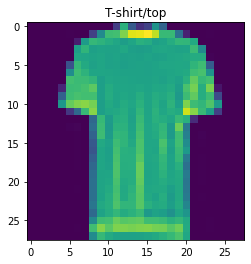

In [7]:
viz_fMNIST_ex(0)

In [8]:
# turn images into a data matrix
Xflat = [np.reshape(x, (1, -1)) for x in X]
Xmat = np.vstack(Xflat)

Xmat.shape

(10000, 784)

__Exercise 1.2:__ Use the random projection function you wrote above to project the fashion MNIST data down to $k=100$ dimensions.

In [9]:
Xproj = random_proj(Xmat, 100)
Xproj.shape

(10000, 100)

In [10]:
def distortion_example():
    # select two data points
    i,j = np.random.choice(len(X), 2, replace=False)
    
    # plot
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(X[i])
    
    plt.subplot(1,2,2)
    plt.imshow(X[j])
    
    plt.show()
    
    # compute their distance in original feature space
    dist_orig = np.linalg.norm(Xmat[i,:]-Xmat[j,:])
    print('Distance in orignal space: {:.3f}'.format(dist_orig))
    
    # compute distance in new feature space
    dist_proj = np.linalg.norm(Xproj[i,:]-Xproj[j,:])
    print('Distance in projected space: {:.3f}'.format(dist_proj))
    
    print('Ratio: {:.5f}'.format(dist_proj/dist_orig))

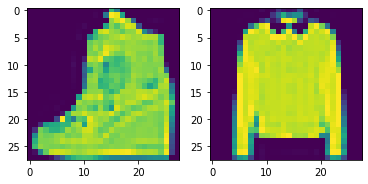

Distance in orignal space: 4459.957
Distance in projected space: 3138.235
Ratio: 0.70365


In [11]:
distortion_example()

__Exercise 1.3:__ Run these comparisons for many examples and different settings of $k$. How does the average distortion vary as a function of $k$?

In [ ]:
# implementation left to the reader: requires an outer loop over functions defined above, then plot

## 2. Dimension reduction via principal components

Instead of randomly projecting, it is reasonable to ask whether we might be able to use the data itself to create a subset of particularly informative features.

##### Principal components

One statistical way to formalize the question above is to ask: what linear combination of features yields the _maximum_ variance? A single linear combination of the features reduces the dimension of $X$ from $d$ to 1. By maximizing the variance, we preserve as much of the variation in $X$ as possible in a single feature. 

Let $w \in \mathbb{R}^{d\times 1}$ denote the coefficients of this linear combination. Then it is given by 
$Xw$, and the variance is

$$
\text{Var}(Xw) = w^T \text{Var}(X) w.
$$

The variance $\text{Var}(X)$ is always positive semidefinite, so the quantity above is always $\geq 0$. However, maximizing directly over $w$ leads to a scaling issue: rather than learning anything about $X$, we could just set $w$ to be arbitrarily large. We therefore constrain the maximization so that it is over all vectors $w$ with _unit norm_:

\begin{align*}
\text{argmax}_{w \in \mathbb{R}^d} &\ \ w^T \text{Var}(X) w \\
\text{subject to} &\ \ ||w||_2^2 = 1.
\end{align*}

The $w$ that solves this optimization problem is called the _first principal component_, or _top principal component_.

##### Subsequent PCs

Subsequent principal components are defined in a similar manner, with the further constraint that they are required to be _orthogonal_ to each previous principal component. That is, the $k^{th}$ previous component solves

\begin{align*}
\text{argmax}_{w \in \mathbb{R}^d} &\ \ w^T \text{Var}(X) w \\
\text{subject to} &\ \ ||w||_2^2 = 1 \\
&\ \ \langle w^{(j)}, w \rangle = 0, \ \ j=1, \dots, k-1.
\end{align*}

The orthogonality constraint ensures that the principal component features are uncorrelated.


##### PCs of fMNIST data

Let's see how this looks on fashion MNIST.

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=10).fit(Xmat) # limit to top 10 PCs

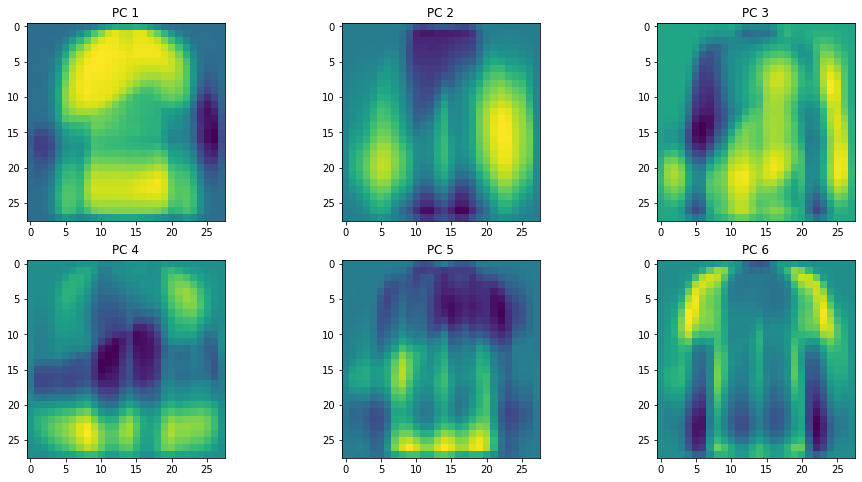

In [14]:
plt.subplots(2,3, figsize=(16,8))

for n in range(6):
    plt.subplot(2,3,n+1)
    plt.imshow(np.reshape(pca.components_[n], (28, -1)))
    plt.title('PC {}'.format(n+1))

__Exercise 1.4:__ Check that the top 2 PCs found by sklearn are orthogonal and have unit norm.

In [15]:
pcs = np.hstack([pca.components_[n][:, None] for n in range(2)])
np.dot(pcs.T, pcs)

array([[1.0000000e+00, 3.6429193e-17],
       [3.6429193e-17, 1.0000000e+00]])

##### Eigenvalues and eigenvectors

So how are the PCs being computed? Let's consider the case of the first PC $w$. Rather than using an optimization algorithm, we'll show that the solution is given exactly in terms of the eigenvectors and eigenvalues of $\text{Var}(X)$. Let's recall what those are:

__Definition__: A vector $v$ and real number $\lambda$ are an _eigenvector_ and corresponding _eigenvalue_ of a square matrix $M$ if $||v||_2 = 1$ and

$$
Mv = \lambda v.
$$

__Properties__: Eigenvectors and eigenvalues are a central concept in linear algebra with many important properties. Here we recall only those relevant to PCA. Throughout, we assume that $M$ is symmetric and positive definite - which will be the case, for example, when $M$ is a covariance matrix.

- The eigenvalues $\lambda$ are all non-negative.

- The eigenvectors are _orthogonal_. That is, if $v_1$ and $v_2$ are eigenvectors of $M$, then $\langle x_1, x_2 \rangle = 0$.

- The eigenvectors form a _basis_. That is, for _any_ vector $x\in \mathbb{R}^d$, we can write 

$$
x = \sum_{i=1}^d a_i v_i
$$

where the $a_i$'s are some vector of coefficients. Note that by the two properties above, $||x||_2^2 = ||a||_2^2$.


##### The first PC is the top eigenvector of the covariance

Now let's return to the problem of finding the top principal component. Recall that we need to solve

\begin{align*}
\text{argmax}_{w \in \mathbb{R}^d} &\ \ w^T \text{Var}(X) w \\
\text{subject to} &\ \ ||w||_2^2 = 1.
\end{align*}

Now let $(v_1, ..., v_d)$ be the eigenvectors of $\text{Var}(X)$, with corresponding eigenvalues $(\lambda_1, ..., \lambda_d)$. Recall that we can write _any_ $w$ as $w = \sum_{i=1}^d a_i v_i$, where the constraint $||x||_2^2 = 1$ is equivalent to  $||a||_2^2 = 1$. Then we can re-write the objective as

\begin{align*}
w^T \text{Var}(X) w &= \left(\sum_{i=1}^d a_i v_i\right)^T \text{Var}(X) \left(\sum_{i=1}^d a_i v_i\right) \\
&= \sum_{i=1}^d a_i^2 v_i^T \text{Var}(X) v_i \\
&= \sum_{i=1}^d a_i^2 v_i^T (\lambda_i v_i) \\
&= \sum_{i=1}^d a_i^2 \lambda_i ||v_i||_2^2 \\
&= \sum_{i=1}^d a_i^2 \lambda_i,
\end{align*}

subject to $||a||_2^2 = 1$. But the $\lambda_i$ are all non-negative, so the maximum value for this expression simply comes from setting the weight $a_i = 1$, where $i$ corresponds to the largest eigenvalue. This means that the best choice of $w$ is simply the "top" eigenvector of $\text{Var}(X)$, where "top" means "has the largest corresponding eigenvalue."

__Exercise 1.5:__ Compute the empirical covariance matrix of the fashion MNIST data $X$ by subtracting the column-wise mean and computing

$$
V_X = \frac{1}{n} X^TX.
$$

Then use `np.linalg.eig()` to obtain the eigenvalues and eigenvectors of $V_X$.

In [16]:
Xmat_std = (Xmat - np.mean(Xmat, axis=0))
Xcov = (1/Xmat_std.shape[0])*np.dot(Xmat_std.T, Xmat_std)

evals, evecs = np.linalg.eig(Xcov)

__Exercise 1.6:__ Find and plot the top eigenvector of $V_X$. Compare this to the top PC found by sklearn.

In [17]:
pc_order = np.argsort(evals)[::-1] # sort to get top eigenvector

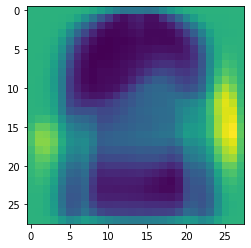

In [18]:
plt.imshow(np.reshape(evecs[:, pc_order[0]], (28, -1)));

In [19]:
# get second eigenvector by deflating
Xcov_deflate = Xcov - evals[pc_order[0]]*np.outer(evecs[:, pc_order[0]], evecs[:, pc_order[0]])

In [20]:
evals_deflate, evecs_deflate = np.linalg.eig(Xcov_deflate)
pc_order_deflate = np.argsort(evals_deflate)[::-1] # sort to get top eigenvector

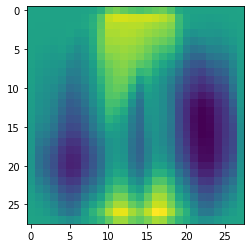

In [21]:
plt.imshow(np.reshape(evecs_deflate[:, pc_order_deflate[0]], (28, -1)))

##### Further considerations

    1. Projecting the data onto the top k PCs.


Projecting $X$ onto the PC features is straightforward: given PCs $v_1, ..., v_k$, construct the matrix $W \in \mathbb{R}^{d\times k}$ by horizontally stacking the PCs. Project the data by computing

$$
X_{\text{Proj}} = XW.
$$

    2. Selecting the number of PCs.

We have already seen an interpretation of the principal components as orthogonal features that explain as much of the variance in the data as possible. The variance explained by each PC $v_i$ is simply the corresponding eigenvalue $\lambda_i$, and the total variance of the data is given by the sum over all PCs. Therefore, the fraction of variance explained for each PC is

$$
EV_i = \frac{\lambda_i}{\sum_{i=1}^d \lambda_i}.
$$

And the total variance explained by the top $k$ PCs is

$$
TV_k = \sum_{i=1}^k EV_i.
$$

One natural way to select the number of PCs is then to specify a fraction of the total variance we wish to explain (say 90%) and take the number of PCs required to do so.

In [24]:
# project centered data onto top 3 PCs
Xproj = np.dot(Xmat_std, evecs[:, pc_order[:3]])
Xproj_sk = PCA(n_components=3).fit_transform(Xmat)

In [25]:
Xproj[:5]

array([[-729.77228985, -778.1386881 ,  152.88043515],
       [-551.38166372, -886.93568185,  201.8563354 ],
       [ 398.81961195, -903.81456119, -163.5984241 ],
       [ 863.99296612, -792.04290397, -379.70954419],
       [ -52.55069031, -903.69321185,   10.10272991]])

In [26]:
Xproj_sk[:5] # identification up to sign

array([[ 729.77228985, -778.13868809,  152.88041438],
       [ 551.38166372, -886.93568185,  201.85630857],
       [-398.81961195, -903.81456116, -163.59840569],
       [-863.99296612, -792.04290397, -379.70956108],
       [  52.55069031, -903.69321186,   10.10270553]])

__Exercise 1.7:__ Implement a method to compute the variance explained by each PCs, given the eigenvalues of $V_X$. Implement a method to compute the _total_ variance explained by the top $k$ PCs, given the eigenvalues of $V_X$. How many PCs are required to explain 90% of the variance in the fashion MNIST data?


In [27]:
def explained_var(evals, pc_order):
    return evals[pc_order] / np.sum(evals[pc_order])

def cumulative_explained_var(evals, pc_order):
    return np.cumsum(explained_var(evals, pc_order))

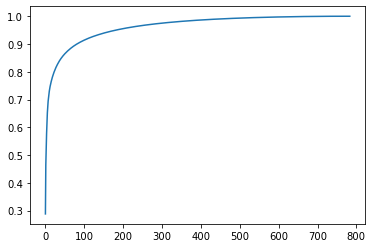

In [28]:
cev = cumulative_explained_var(evals, pc_order)
plt.plot(cev)

In [29]:
np.sum(cev < 0.9)

81

In [30]:
cev[81]

0.9000257137834111

## 3. Differential Privacy

### 3.1. Terminology and Notation

- **Curator:** Data holder, assumed to be trusted. Makes a promise to data subject: "You will not be affected, adversely or otherwise, by allowing your data to be used in any study or analysis, regardless what other studies, data sets, or information sources, are available." 
- **Data analyst:** Wants to analyze the data, can potentially be an attacker who would like to use the data for malicious purposes.
- **Query:** A question, request, or input $x \in \mathcal{X}$ made from the data analyst to the curator. **Note**: This does NOT have to be a feature vector (as in machine learning) but often will be.
- **Response:** An answer or output $y \in \mathcal{Y}$ returned from the curator to the analyst given a query. **Note**: This does NOT have to be a predicted label (as in machine learning) but often will be.
- **Mechanism:** A (possibly randomized) function $M_{\mathcal{D}}: \mathcal{X} \rightarrow \mathcal{Y}$ that produces responses from queries, and depends on an unobserved database $\mathcal{D}$.
- **Neighboring databases:** Two databases (datasets) are called neighboring if they are identical expect for one entry.

### 3.2. Surprising Facts

1. Data cannot be fully anonymized and remain useful. 
2. Re-identification is not the only risk.
3. Queries over large sets are not protective.
4. Query auditing is problematic.
5. Summary statistics are not safe.
6. "Ordinary" facts are not negligible.
7. The "just a few" philosophy is complex. 

### 3.3. Randomized Response

What does work? It has been shown that *injecting noise* into the data can actually improve the privacy of a mechanism, where privacy is the degree to which we can guarantee that data subjects will not be harmed by their inclusion in a mechanism. Consider a database whose entries contain answers to the following.

**Question:** Have you ever dodged taxes?
- Flip a coin.
- If heads, answer the question truthfully.
- If tails, flip another coin.
    - If heads, answer "Yes".
    - If tails, answer "No".
    
Intuitively, this gives any participant plausible deniability if someone ever found out that their answer was "Yes", thereby preventing a certain amount of harm from coming to them. Let's formalize this.

It may be known by an attacker that the response $y \in \{\text{"Yes"}, \text{"No"}\}$ to query $x = \text{Bob's participant ID}$ contains Bob's answer to the question. Bob answered "Yes", and Bob will be investigated if his probability of dodging taxes is high. Let the prior probability (as estimated by Tammy the tax investigator) of Bob dodging be
$$
\mathbb{P}(\text{dodge}) = 0.02
$$
Based on the set up, we have the probabilities of answers given whether the participant dodged or not is
$$
\begin{align*}
\mathbb{P}(\text{"Yes"} \mid \text{dodge}) &= \frac{3}{4}\\
\mathbb{P}(\text{"No"} \mid \text{dodge}) &= \frac{1}{4}\\
\mathbb{P}(\text{"Yes"} \mid \text{no dodge}) &= \frac{1}{4}\\
\mathbb{P}(\text{"No"} \mid \text{dodge}) &= \frac{3}{4}
\end{align*}
$$
**Exercise 3.1:** Verify the probabilities above on your own.

By Bayes' Rule, it can be shown that
$$
\mathbb{P}(\text{dodge} \mid \text{"Yes"}) = 0.058
$$
By some measure, Tammy's beliefs have not shifted too much after noticing that Bob answered "Yes". Thus, Bob is protected in a sense by participating in the survey. There is merit to injecting randomness into the responses.

**Exercise 3.2:** Verify the probability above on your own via Bayes' Rule.

$$
\mathbb{P}(\text{dodge} \mid \text{"Yes"}) = \frac{\mathbb{P}(\text{"Yes"} \mid \text{dodge}) * \mathbb{P}(\text{dodge})}{ \mathbb{P}(\text{"Yes"} \mid \text{dodge}) * \mathbb{P}(\text{dodge}) + \mathbb{P}(\text{"Yes"} \mid \text{no dodge}) * \mathbb{P}(\text{no dodge}) } = \frac{0.75 * 0.02}{0.75 * 0.02 + 0.25 * 0.98} = 0.02
$$

### 3.4. Definition of Differential Privacy

We saw in the above example that privacy was achieved when probabilities surrounding a response did not shift by too by virtue of a single data point. A *mechanism* is called $\epsilon$-**differentially private** if for any query $x$, any set of responses $\mathcal{R} \subseteq \mathcal{Y}$, and any neighboring databases $\mathcal{D}_1$ and $\mathcal{D}_2$,
$$
\mathbb{P}\left(M_{\mathcal{D_1}}(x) \in \mathcal{R}\right) \leq \text{exp}(\epsilon) \cdot \mathbb{P}\left(M_{\mathcal{D_2}}(x) \in \mathcal{R}\right).
$$
This probability is taken over the randomness of the mechanism $M$. In other words,
$$
\text{exp}(-\epsilon) \leq \frac{\mathbb{P}\left(M_{\mathcal{D_1}}(x) \in \mathcal{R}\right)}{\mathbb{P}\left(M_{\mathcal{D_2}}(x) \in \mathcal{R}\right)} \leq \text{exp}(\epsilon)
$$
or
$$
-\epsilon \leq \log \mathbb{P}\left(M_{\mathcal{D_1}}(x) \in \mathcal{R}\right) - \log \mathbb{P}\left(M_{\mathcal{D_2}}(x) \in \mathcal{R}\right) \leq \epsilon.
$$
![norms](img/diff_privacy.png)

### 3.5. Gaussian Mechanism

As seen before, differential privacy can be achieved by *injecting noise* into the response for a given query. The idea is that if responses have some amount of noise, it is harder to use these responses to identify whether a certain datapoint was used coming up with the response. To understand this phenomenon, first we will implement a checker that inspects whether a mechanism is differentially private by simulation.

In [1]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.linear_model import LogisticRegression

In [2]:
class Mechanism:
    
    @abstractmethod
    def __init__(self, database, **kwargs):
        pass
    
    @abstractmethod
    def respond(query):
        pass

Our setup is as follows. The database $\mathcal{D} = (x_1, y_1), ..., (x_n, y_n)$ contains i.i.d. draws from from the following distribution on $(x, y)$.
$$
\begin{align*}
x &\sim \mathcal{N}(0, 1)\\
y \mid x &= \begin{cases}
1 &\text{ if } x > 0\\
0 &\text{ if } x \leq 0
\end{cases}
\end{align*}
$$
The mechanism $M_{\mathcal{D}}$ trains a logistic regression model $(\hat{\beta}_0, \hat{\beta}_1)$ on $\mathcal{D}$, and then predicts using
$$
\hat{p}(y=1\mid x) = \frac{1}{1 + \text{exp}\left(\hat{\beta}_1 \cdot x + \hat{\beta}_0\right)}
$$

The **Gaussian mechanism** will be our first attempt at injecting noise to achieve privacy. Before going through the sigmoid function, we will add a random variable $\epsilon \sim \mathcal{N}(0, \sigma^2)$ to the logits, and return
$$
\hat{p}_{\text{DP}}(y=1\mid x) = \frac{1}{1 + \text{exp}\left(\hat{\beta}_1 \cdot x + \hat{\beta}_0 + \epsilon\right)}
$$
We have yet to see whether this will actually achieve the definition.

**Exercise 3.3:** Implement the `GaussienMechanism` below.

In [10]:
class GaussianMechanism(Mechanism):
    
    def __init__(self, database, sigma2):
        X, y = database
        self.model = LogisticRegression().fit(X, y)
        self.sigma2 = sigma2 # Parameter for noise.
        
    def respond(self, query):
        """
        'query' is a numpy.ndarray that contains one feature vector. 
        Return the label after having applied the Gaussian Mechanism.
        """
        ## Solution:
        x = query + np.sqrt(self.sigma2) * np.random.normal()
        y = self.model.predict(x.reshape(1, -1))[0]
        ##
        return y

In [11]:
np.random.seed(1234)

n = 100

X = np.random.normal(size=(n, 1))
y = (X > 0).reshape((n,)).astype(int)

database = (X, y)
sigma2 = 0.49

gm1 = GaussianMechanism(database, sigma2)

query = 0.001
gm1.respond(query)

1

**Exercise 3.4.** Implement a simulation-based differential privacy checker to check whether a mechanism is differentially private. 

**Note:** In this setting it is only computationally feasible to decide whether a mechanism is decidedly not differentially private or that it is unknown. Here, we check the condition for one particular instance of $x$, $\mathcal{D}_1$, and $\mathcal{D}_2$.

In [12]:
def is_in_response_region(y):
    return y == 1

def check_differentially_private(epsilon, mechanism1, mechanism2, query, is_in_response_region, num_sims=1000):
    
    y1 = []
    y2 = []
    for i in range(num_sims):
        # Collect responses of each mechanism into 'y1' and 'y2'.
        ## Solution:
        y1.append(mechanism1.respond(query))
        y2.append(mechanism2.respond(query))
        ##
       
    # Compute probability that the responses are in the response region.
    ## Solution:
    prob1 = is_in_response_region(np.array(y1)).sum() / num_sims
    prob2 = is_in_response_region(np.array(y2)).sum() / num_sims
    ##
    
    # Check definition, and set to Boolean below.
    ## Solution:
    is_differentially_private = (prob1 <= np.exp(epsilon) * prob2)   
    ##
    
    return is_differentially_private

In [13]:
np.random.seed(1234)

X2, y2 = X.copy(), y.copy()

X2[0, 0] = 1 - X[0, 0]

gm2 = GaussianMechanism((X2, y2), sigma2)
epsilon = 0.001


# Should be False.
check_differentially_private(epsilon, gm1, gm2, query, is_in_response_region)

False

Clearly, it is not true that *any* noise will work. 
![norms](img/gaussian.png)
Moreover, checking the defining condition by simulation can be difficult, and enumeration is computationally intensive. Luckily, there are mechanisms that are provably differentially private. 

### 3.6. Laplace Mechanism

The **Laplave mechanism** is similar to the above, except $\epsilon \sim \text{Laplace}(0, b)$, with probability density function given by:
$$
f(\epsilon; b) = \frac{1}{2b}\exp\left(-\frac{|\epsilon|}{b}\right)
$$
![norms](img/laplace.png)

**Exercise 3.5:** Implement the Laplace mechanism above.

In [17]:
class LaplaceMechanism(Mechanism):
    
    def __init__(self, database, scale):
        X, y = database
        self.model = LogisticRegression().fit(X, y)
        self.scale = scale # Parameter for noise.
        
    def respond(self, query):
        ## Solution:
        x = query + np.random.laplace(scale=self.scale)
        y = self.model.predict(np.array([x]).reshape(1, -1))[0]
        ##
        return y

In [18]:
scale = 0.7

lm1 = LaplaceMechanism((X, y), scale)
lm2 = LaplaceMechanism((X2, y2), scale)

# Should be True.
check_differentially_private(epsilon, lm1, lm2, query, is_in_response_region)

True

Even at the same amount of variance, the Laplace mechanism did not fail the check, while the Gaussian mechanism did.